In [1]:
import torch
import numpy as np
import foolbox as fb
import itertools as it

import sys
sys.path.append("monotone_op_net")
import train
import splitting as sp

import torch.nn as nn
from matplotlib import pyplot as plt
%matplotlib inline

<h2> Load FC monDEQ model trained on MNIST

In [34]:
# MNIST Dataloaders
trainLoader, testLoader = train.mnist_loaders(train_batch_size=128, test_batch_size=500)
def cuda(tensor):
    if 0:
        return tensor.cuda()
    else:
        return tensor

# Instantiate and load monDEQ model
m = 20
h = 40
model = train.SingleFcNet(sp.MONPeacemanRachford,
                        in_dim=28**2,
                        out_dim=h,
                        alpha=1.0,
                        max_iter=300,
                        tol=1e-5,
                        m=m)

model.load_state_dict(torch.load("models/mon_h40_m20.0.pt", map_location=torch.device('cpu')))
model.eval()

with torch.no_grad():
    total_cnt = 0
    correct = 0
    for batch in testLoader:
        data, target = cuda(batch[0]), cuda(batch[1])
        preds = model(data)
        target = target.numpy()
        preds = preds.numpy()
        correct += np.sum(np.equal(np.argmax(preds, axis=1), target).astype(int))
        total_cnt += len(target)
print("monDEQ test error = %.3f" % (1-correct / total_cnt))

monDEQ test error = 0.044


In [16]:
# Compute certified robustness on a range of \epsilon values
L = np.linalg.norm(model.Wout.weight.detach(),ord=2) * \
    np.linalg.norm(model.mon.linear_module.U.weight.detach(),ord=2) / m # Lipschitz constant of monDEQ
print("L =", L)
num = 10
epsilons = np.linspace(0.01, 0.2, num=num)
epsilons = epsilons / 0.3081 # Scaling due to mean-std normalization in MNIST dataloader

acc_list_mon = []
m_list = []
with torch.no_grad():
    for eps in epsilons:
        print("Eps = %.3f" % eps)
        C = L * eps
        cnt = 0
        total_cnt = 0
        for batch in testLoader:
            data, target = cuda(batch[0]), cuda(batch[1])
            preds = model(data)
            preds = preds.numpy()
            target = target.numpy()
            for i in range(len(target)):
                if np.argmax(preds[i, :]) == target[i]:
                    second = preds[i, np.argsort(-preds[i, :])[1]]
                    first = preds[i, np.argsort(-preds[i, :])[0]]
                    margin = first - second
                    m_list.append(margin)
                    if C <= margin/2: # check if condition satisfied for certified robustness
                        cnt += 1
            total_cnt += len(target)
        acc_list_mon.append(cnt/total_cnt)

L = 3.83663330078125
Eps = 0.032
Eps = 0.101
Eps = 0.169
Eps = 0.238
Eps = 0.307
Eps = 0.375
Eps = 0.444
Eps = 0.512
Eps = 0.581
Eps = 0.649


<h2> Load DNN model trained on MNIST

In [29]:
# Instantiate and load DNN model
d = 3
h = 40
model = nn.Sequential(nn.Flatten(),
                              nn.Linear(784, h),nn.ReLU(),
                              *it.chain(*[[nn.Linear(h,h),nn.ReLU()] for _ in range(d-2)]),
                              nn.Linear(h,10))
model.load_state_dict(torch.load("models/dnn_d3.pt", map_location=torch.device('cpu')))
model.eval()

with torch.no_grad():
    total_cnt = 0
    correct = 0
    for batch in testLoader:
        data, target = cuda(batch[0]), cuda(batch[1])
        preds = model(data)
        target = target.numpy()
        preds = preds.numpy()
        correct += np.sum(np.equal(np.argmax(preds, axis=1), target).astype(int))
        total_cnt += len(target)
print("DNN test error = %.3f" % (1-correct / total_cnt))

DNN test error = 0.029


In [27]:
num = 10
epsilons = np.linspace(0.01, 0.2, num=num)
epsilons = epsilons / 0.3081
L = 14.146 # As computed by SDP-Neuron method in Fazylab et al. 2019
acc_list_dnn = []
m_list = []
with torch.no_grad():
    for eps in epsilons:
        print("Eps = %.3f" % eps)
        C = L * eps
        cnt = 0
        total_cnt = 0
        for batch in testLoader:
            data, target = cuda(batch[0]), cuda(batch[1])
            preds = model(data)
            preds = preds.numpy()
            target = target.numpy()
            for i in range(len(target)):
                if np.argmax(preds[i, :]) == target[i]:
                    second = preds[i, np.argsort(-preds[i, :])[1]]
                    first = preds[i, np.argsort(-preds[i, :])[0]]
                    margin = first - second
                    m_list.append(margin)
                    if C <= margin/2:
                        cnt += 1
            total_cnt += len(target)
        acc_list_dnn.append(cnt/total_cnt)

Eps = 0.032
Eps = 0.101
Eps = 0.169
Eps = 0.238
Eps = 0.307
Eps = 0.375
Eps = 0.444
Eps = 0.512
Eps = 0.581
Eps = 0.649


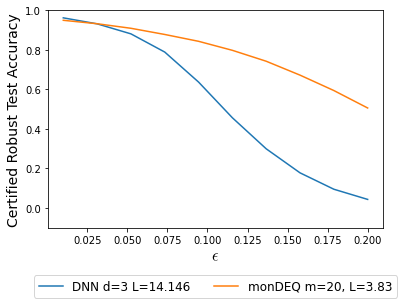

In [33]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.plot(epsilons * 0.3081, acc_list_dnn, label="DNN d=3 L=14.146")
plt.plot(epsilons * 0.3081, acc_list_mon, label="monDEQ m=20, L=3.83")
plt.xlabel("$\epsilon$", fontsize=16)
plt.ylabel("Certified Robust Test Accuracy", fontsize=14)
plt.ylim(-0.1, 1)
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', fontsize=12, ncol=2)

<h2> Validating Robustness of monDEQs against PGD attacks

In [4]:
# Load monDEQ model
m = 20
h = 40
model = train.SingleFcNet(sp.MONPeacemanRachford,
                        in_dim=28**2,
                        out_dim=h,
                        alpha=1.0,
                        max_iter=300,
                        tol=1e-5,
                        m=m)

model.load_state_dict(torch.load("models/mon_h40_m20.0.pt", map_location=torch.device('cpu')))
model.eval()

SingleFcNet(
  (mon): MONPeacemanRachford(
    (linear_module): MONSingleFc(
      (U): Linear(in_features=784, out_features=40, bias=True)
      (A): Linear(in_features=40, out_features=40, bias=False)
      (B): Linear(in_features=40, out_features=40, bias=False)
    )
    (nonlin_module): MONReLU()
  )
  (Wout): Linear(in_features=40, out_features=10, bias=True)
)

In [8]:
trainLoader, testLoader = train.mnist_loaders(train_batch_size=128, test_batch_size=500)

# Run PGD attack (Foolbox tool) on monDEQ for a range of \epsilon values
bounds = (-0.424212917883804, 2.82148653034729)
fmodel = fb.PyTorchModel(model, bounds=bounds)
attack = fb.attacks.L2ProjectedGradientDescentAttack()
num = 15
epsilons = np.linspace(0.1, 1.5, num=num)
epsilons = epsilons / 0.3081
print(epsilons)
robust_accuracy = np.zeros(num)
total_cnt = 0
for i, batch in enumerate(testLoader):
    print(i, end="\r")
    data, target = cuda(batch[0]), cuda(batch[1])
    raw, clipped, is_adv = attack(fmodel, data, target, epsilons=epsilons)
    is_adv = is_adv.type(torch.FloatTensor)
    ra = 1 - is_adv.mean(axis=-1).numpy()
    ra = ra * len(target)
    robust_accuracy += ra
    total_cnt += len(target)

[0.32456994 0.64913989 0.97370983 1.29827978 1.62284972 1.94741967
 2.27198961 2.59655956 2.9211295  3.24569945 3.57026939 3.89483934
 4.21940928 4.54397923 4.86854917]


In [10]:
# Load DNN model
h = 40
d = 10
model = nn.Sequential(nn.Flatten(),
                              nn.Linear(784, h),nn.ReLU(),
                              *it.chain(*[[nn.Linear(h,h),nn.ReLU()] for _ in range(d-2)]),
                              nn.Linear(h,10))
model.load_state_dict(torch.load("models/dnn_d10.pt", map_location=torch.device('cpu')))
model.eval()

# Run PGD attack (Foolbox tool) on DNN for a range of \epsilon values
bounds = (-0.424212917883804, 2.82148653034729)
fmodel = fb.PyTorchModel(model, bounds=bounds)

attack = fb.attacks.L2ProjectedGradientDescentAttack()

num = 15
epsilons = np.linspace(0.1, 1.5, num=num)
epsilons = epsilons / 0.3081
robust_accuracy_dnn = np.zeros(num)
total_cnt = 0

for i, batch in enumerate(testLoader):
    print(i, end="\r")
    data, target = cuda(batch[0]), cuda(batch[1])
    raw, clipped, is_adv = attack(fmodel, data, target, epsilons=epsilons)
    is_adv = is_adv.type(torch.FloatTensor)
    ra = 1 - is_adv.mean(axis=-1).numpy()
    ra = ra * len(target)
    robust_accuracy_dnn += ra
    total_cnt += len(target)
robust_accuracy_dnn /= total_cnt
print(robust_accuracy_dnn)

[0.9587     0.9387     0.9138     0.8797     0.8344     0.7793
 0.70680001 0.63080001 0.5447     0.47009999 0.39850001 0.3373
 0.28029999 0.2333     0.1885    ]


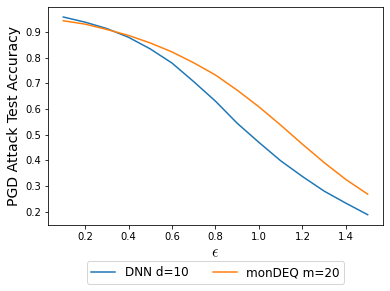

In [12]:
epsilons = np.linspace(0.1, 1.5, num=num)

plt.rcParams["mathtext.fontset"] = "cm"
plt.plot(epsilons, robust_accuracy_dnn, label="DNN d=10")
plt.plot(epsilons, robust_accuracy, label="monDEQ m=20")
plt.ylabel("PGD Attack Test Accuracy", fontsize=14)
plt.xlabel("$\epsilon$", fontsize=16)
# plt.legend(fontsize=12)
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='lower center', fontsize=12, ncol=2)